<a href="https://www.kaggle.com/code/kuntalpal/forward-forward-algorithm?scriptVersionId=116122187" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This notebook is an implementation of the Forward-Forward (FF) algorithm presented at [Geoffrey Hinton's talk at NeurIPS 2022](https://www.cs.toronto.edu/~hinton/FFA13.pdf). The conventional backprop computes the gradients by successive applications of the chain rule, from the objective function to the parameters. FF, however, computes the gradients locally with a local objective function, so there is no need to backpropagate the errors.

I use the MNIST dataset for testing the new algorithm as suggested in the paper.

The code is mainly inspired by pytorch implementation in this [repo](https://github.com/mohammadpz/pytorch_forward_forward).

In [1]:
# Load the libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import keras.datasets as kds
import keras.backend as K
from tqdm.auto import tqdm

In [2]:
# Load the MNIST dataset

def MNIST_loaders(batch_size):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    # convert data to float32 and scale it to the [0, 1] range
    x_train, x_test = x_train/255.0, x_test/255.0

    # create dataset and data loader objects
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(10000)
    train_loader = iter(train_dataset)
    test_loader = iter(test_dataset)

    return train_loader, test_loader

In [3]:
# Parameters of the model
# set random seed
tf.random.set_seed(1234)

# load and preprocess MNIST data
num_epochs = 1000
batch_size = 1000

dims = [784,500,500]
learning_rate = 0.001

The local objective function (goodness function) is simply the sum of the squares of the activities of the rectified linear neurons in that layer. The aim of the learning is to make the goodness be well above some threshold value ($\theta$) for real data and well below that value for negative data. i.e.

$$
  G(x) := \sum_{i} ReLU (h_{i})^{2}
$$
A positive sample s is a real datapoint with a large P(s) under the training distribution.

$$
G(s) >> \theta
$$

A negative sample s$^{'}$ is a fake datapoint with a small P(s$^{'}$) under the training distribution.
$$
G(s^{'}) << \theta
$$

# How to create negative data for supervised learning task

As suggested in the paper, one way to create negative data for FF is to include the label in the input. The positive data consists of an image with the correct label and the negative data consists of an image with the incorrect label. Since the only difference between positive and negative data is the label, FF will ignore all features of the image that do not correlate with the label.


MNIST images contain a black border to make life easy for convolutional neural nets. We replace the first 10 pixels by a one of N representation of the label.

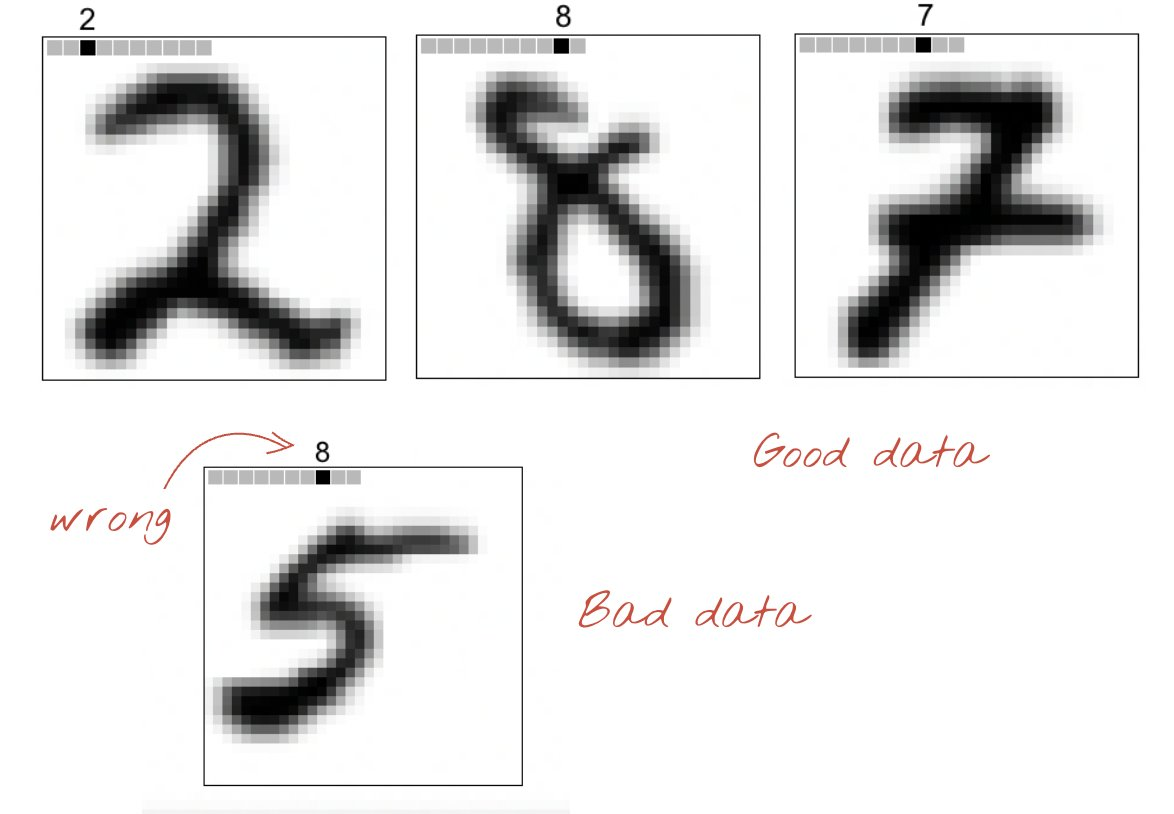

Source: [twitter ](https://twitter.com/martin_gorner/status/1599759770608549888)

In [4]:
def edit_image(x, y, method="edit"):
    is_batch = x.ndim == 3
    if method == "edit":
        if is_batch:
            x[:, 0, :10] = 0.0
            for i in range(x.shape[0]):
                x[i, 0, y[i]] = 1.0
        else:
            x[0, :10] = 0.0
            x[0, y] = 1.0

In [5]:
def random_label(y):
    if type(y) != np.ndarray:
        label = list(range(10))
        del label[y]
        return np.random.choice(label)
    else:
        label = np.copy(y)
        for i in range(y.shape[0]):
            label[i] = random_label(y[i])
        return label

In [6]:
train_loader, test_loader = MNIST_loaders(60000)
x_train, y_train = next(iter(train_loader))
x_test, y_test = next(iter(test_loader))

x_pos = np.copy(x_train)
x_neg = np.copy(x_train)
y_train = np.copy(y_train)
edit_image(x_pos, y_train)
edit_image(x_neg, random_label(y_train))

11501568/11490434 [==============================] - 1s 0us/step


2023-01-11 10:12:36.842312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 10:12:36.977659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 10:12:36.978450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 10:12:36.980769: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## The loss function

In [7]:
def FFLoss_with_threshold(threshold):
  def FF_Loss(y_true, y_pred):
    g = K.mean(y_pred**2, axis=1)
    g = g - threshold
    g = g * y_true
    loss = K.log(1 + K.exp(g))
    loss = K.mean(loss)
    return loss
  return FF_Loss

def normalize_FF(x_):
    return x_ / (tf.norm(x_, ord=2, axis=1, keepdims=True) + 1e-4)


In [8]:
x_pos = x_pos.reshape(x_pos.shape[0], -1)
x_neg = x_neg.reshape(x_neg.shape[0], -1)

layer0_input = tf.data.Dataset.from_tensor_slices((x_pos, x_neg)).batch(batch_size)

In [9]:
# Define the individual layers

model_layers = []
for d in range(len(dims) -1):
    model_layers.append(tf.keras.Sequential([
        tf.keras.layers.Dense(dims[d+1], activation="relu", input_shape=[dims[d]])
    ], name=f'model_{d}'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model layers
for i in range(len(model_layers)):
    model_layers[i].compile(loss=FFLoss_with_threshold(2), optimizer=optimizer)

In [ ]:
y_pos = np.ones((batch_size)) * -1
y_neg = np.ones((batch_size))

for ep in tqdm(range(num_epochs)):
  for x_pos,x_neg in layer0_input:
  
    model_layers[0].train_on_batch(x_pos, y_pos)
    model_layers[0].train_on_batch(x_neg, y_neg)

  0%|          | 0/1000 [00:00<?, ?it/s]

2023-01-11 10:12:44.707996: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-11 10:12:45.956183: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-11 10:12:47.379031: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-11 10:12:47.389582: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-11 10:12:47.409213: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-11 10:12:47.423461: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-11 10:12:47.442898: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-11 10:12:47.458525: W tensorflow/core/

In [ ]:
# Layer 1 updates
pos_layer1 = normalize_FF(model_layers[0].predict(pos))
neg_layer1 = normalize_FF(model_layers[0].predict(neg))

layer1_update = tf.data.Dataset.from_tensor_slices((pos_layer1, neg_layer1)).batch(batch_size)


In [ ]:
for ep in tqdm(range(1000)):
  for x_pos_layer1,x_neg_layer1 in layer1_update:
  
    model_layers[1].train_on_batch(x_pos_layer1, y_pos)
    model_layers[1].train_on_batch(x_neg_layer1, y_neg)

In [ ]:
def test_FF_model(x, layers):
  goodness_per_label = []
  for i in tqdm(range(10)):
    tmp = np.copy(x)
    edit_image(tmp, np.ones((tmp.shape[0]), dtype=int) * i)
    tmp = tmp.reshape(tmp.shape[0], -1)
    layer1_pred = normalize_FF(layers[0].predict(tmp, verbose=0))

    layer2_pred = layers[1].predict(layer1_pred, verbose=0)
    
    pred = np.mean(np.power(layer1_pred, 2), axis=1) + np.mean(np.power(layer2_pred, 2), axis=1)
    goodness_per_label.append(pred.reshape(-1, 1))

  labels = np.concatenate(goodness_per_label, axis=1)
  return np.argmax(labels, axis=1)

In [ ]:
train_acc = 0
test_acc = 0

train_pred = test_FF_model(x_train, model_layers)
test_pred = test_FF_model(x_test, model_layers)


train_acc = np.sum(train_pred == y_train)
test_acc = np.sum(test_pred == y_test)

train_acc = train_acc / y_train.shape[0] * 100
test_acc = test_acc / y_test.shape[0] * 100

print(f"test acc : {train_acc:.2f}%")
print(f"test acc : {test_acc:.2f}%")